In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import warnings
import seaborn as sns
import numpy as np

# SQL Alchemy
from sqlalchemy import create_engine, event
import time
from datetime import datetime

# PyMySQL 
import pymysql
pymysql.install_as_MySQLdb()

# Config variables
from config import local_db_user, local_db_pwd, local_db_endpoint, local_db_port, local_db_name
from config import remote_db_user, remote_db_pwd, remote_db_endpoint, remote_db_port, remote_db_name

warnings.filterwarnings('ignore')

In [2]:
#import our CSV file
yearly_stats_all_pos_df = pd.read_csv('yearly data/all_players_yearly_stats_2002-2020.csv')
yearly_stats_all_pos_df.head()

,Season,Rk,Player,Team,Pos,Age,Games Played,Games Started,Pass Comp,Pass Att,...,Total TD,2pt Convs Made,2pt Conv Passes,FPts,PPR,DK Fpts,FD Fpts,VBD,Pos Rank,Overall Rank
0,2019,34,A.J. Brown,TEN,WR,22,16,11,0,0,...,9,0,0,165,217.1,220.1,191.1,36,9,34
1,2020,28,A.J. Brown,TEN,WR,23,14,12,0,0,...,12,0,0,178,247.5,251.5,212.5,52,9,28
2,2016,348,A.J. Derby,2TM,TE,25,10,3,0,0,...,0,0,0,14,30.0,34.0,22.0,0,65,0
3,2017,270,A.J. Derby,2TM,TE,26,11,1,0,0,...,2,0,0,34,55.4,59.4,44.9,0,41,0
4,2018,381,A.J. Derby,MIA,TE,27,4,0,0,0,...,1,0,0,11,13.8,13.8,12.3,0,75,0


In [3]:
yearly_stats_all_pos_df.drop(['Rk', '2pt Convs Made', '2pt Conv Passes', 'FPts', 
       'DK Fpts', 'FD Fpts', 'VBD', 'Pos Rank', 'Overall Rank', 'Fumbles', 'Games Started'], axis=1, inplace=True)

In [4]:
yearly_stats_all_pos_df.columns

Index(['Season', 'Player', 'Team', 'Pos', 'Age', 'Games Played', 'Pass Comp',
       'Pass Att', 'Pass Yds', 'Pass TD', 'Pass Int', 'Rush Att', 'Rush Yds',
       'Rush Y/A', 'Rush TD', 'Rec Tgt', 'Receptions', 'Rec Yds', 'Rec Y/R',
       'Rec TD', 'Fumbles Lost', 'Total TD', 'PPR'],
      dtype='object')

In [5]:
#yearly_stats_all_pos_df['FantasyPoints'] = yearly_stats_all_pos_df['Rush Yds']*0.1 + yearly_stats_all_pos_df['Rush TD']*6 + yearly_stats_all_pos_df['Receptions'] + yearly_stats_all_pos_df['Rec Yds']*0.1 + yearly_stats_all_pos_df['Rec TD']*6 - yearly_stats_all_pos_df['Fumbles Lost']*2 + yearly_stats_all_pos_df['Pass Yds']*0.04 + yearly_stats_all_pos_df['Pass TD']*4

In [6]:
yearly_stats_all_pos_df['FantasyPoints'] = yearly_stats_all_pos_df['PPR']

In [7]:
#Create new column for Fantasy points per game.
yearly_stats_all_pos_df['FantasyPoints/Game'] = yearly_stats_all_pos_df['FantasyPoints']/yearly_stats_all_pos_df['Games Played']
yearly_stats_all_pos_df['FantasyPoints/Game'] = yearly_stats_all_pos_df['FantasyPoints/Game'].apply(lambda x: round(x, 2))

In [8]:
yearly_stats_all_pos_df = yearly_stats_all_pos_df[yearly_stats_all_pos_df['Season'] == 2020]

In [9]:
#separate dataframes based off position
rb_df = yearly_stats_all_pos_df[yearly_stats_all_pos_df['Pos'] == 'RB']
qb_df = yearly_stats_all_pos_df[yearly_stats_all_pos_df['Pos'] == 'QB']
wr_df = yearly_stats_all_pos_df[yearly_stats_all_pos_df['Pos'] == 'WR']
te_df = yearly_stats_all_pos_df[yearly_stats_all_pos_df['Pos'] == 'TE']

# Grab Headshots

In [10]:
#bring in roster data
roster_df = pd.read_csv('roster_2020.csv')

#change the player name column to have the same format as our passing_df one
#roster_df['receiver_player_name'] = roster_df['teamPlayers.displayName'].apply(lambda x: '.'.join([x.split()[0][0], x.split()[-1]]))

#filter our results a bit more so we get closer to our solution
roster_df = roster_df.loc[roster_df['position'].isin(['QB', 'RB', 'WR', 'TE']), ['full_name', 'headshot_url']]

#reset the index to a range index 0 -> len(roster_df)
roster_df = roster_df.reset_index(drop=True)

roster_df

,full_name,headshot_url
0,Cole McDonald,https://a.espncdn.com/combiner/i?img=/i/headsh...
1,Kyler Murray,https://a.espncdn.com/combiner/i?img=/i/headsh...
2,Chris Streveler,https://a.espncdn.com/combiner/i?img=/i/headsh...
3,Brett Hundley,https://a.espncdn.com/combiner/i?img=/i/headsh...
4,Kenyan Drake,https://a.espncdn.com/combiner/i?img=/i/headsh...
...,...,...
1496,Marcus Simms,https://a.espncdn.com/combiner/i?img=/i/headsh...
1497,Darius Jennings,https://a.espncdn.com/combiner/i?img=/i/headsh...
1498,Rashawn Scott,https://a.espncdn.com/combiner/i?img=/i/headsh...
1499,Kelvin Benjamin,https://a.espncdn.com/combiner/i?img=/i/headsh...


# RB: Compare usage vs efficiency 

In [11]:
#Create new column for usage per game. Usage is defined as # of targets + carries
rb_df['Usage/Game'] = (rb_df['Rush Att'] + rb_df['Rec Tgt'])/rb_df['Games Played']

#round each row value to two decimal places
rb_df['Usage/Game'] = rb_df['Usage/Game'].apply(lambda x: round(x, 2))

rb_df['Usage'] = rb_df['Rec Tgt'] + rb_df['Rush Att'] # create a new column for usage
rb_df['UsageRank'] = rb_df['Usage'].rank(ascending=False)
rb_df['FantasyPointsRank'] = rb_df['FantasyPoints'].rank(ascending=False)

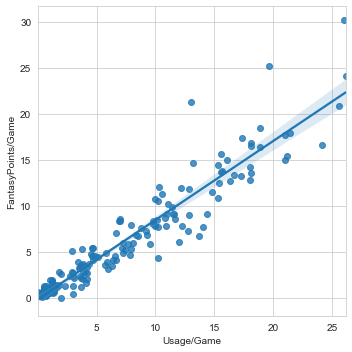

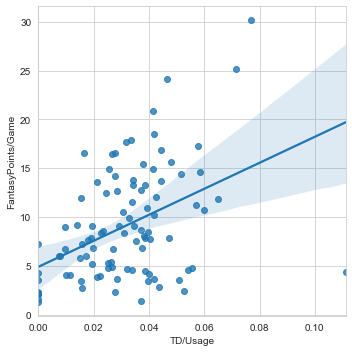

In [12]:
#just for styling. We imported seaborn earlier as sns.
sns.set_style('whitegrid')

#create a canvas with matplotlib
fig, ax = plt.subplots()
fig.set_size_inches(5,5)

#basic regression scatter plot with trendline
plot = sns.regplot(
x=rb_df['Usage/Game'],
y=rb_df['FantasyPoints/Game'],
scatter=True,)

plt.tight_layout();
plt.savefig('../static/images/RB_usage_per_game', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)


#How does efficiency correlate to fantasy football performance?
rb_df['TD/Usage'] = (rb_df['Rush TD']+ rb_df['Rec TD'])/(rb_df['Rush Att'] + rb_df['Rec Tgt'])
fig, ax = plt.subplots()
fig.set_size_inches(5,5)

#Make sure there is an adequete sample size
rb_df = rb_df[rb_df['Rush Att'] > 20]
plot = sns.regplot(
x=rb_df['TD/Usage'],
y=rb_df['FantasyPoints/Game'],
scatter=True)

plt.tight_layout();
plt.savefig('../static/images/RB_TD_per_usage', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

In [13]:
from sklearn.model_selection import train_test_split
X = rb_df['Usage'].values.reshape(-1, 1)
Y = rb_df['FantasyPoints'].values.reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [14]:
regressor = LinearRegression()  
regressor.fit(x_train, y_train) #training the algorithm
y_pred = regressor.predict(x_test)

In [15]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df.head()

,Actual,Predicted
0,56.9,40.305678
1,33.2,26.352062
2,164.6,178.097636
3,71.8,61.236102
4,21.0,25.479961


In [16]:
rb_df['FantasyPointPrediction'] = regressor.predict(X) # create a new column for usage

#round each row value to two decimal places
rb_df['FantasyPointPrediction'] = rb_df['FantasyPointPrediction'].apply(lambda x: round(x, 1))

In [17]:
rb_df_with_headshots = rb_df.merge(roster_df, left_on='Player', right_on='full_name', how='left')
rb_df_with_headshots = rb_df_with_headshots.sort_values(by='UsageRank')   

#reset the index to a range index 0 -> length
rb_df_with_headshots = rb_df_with_headshots.reset_index(drop=True)

rb_df_with_headshots.head(10) 

,Season,Player,Team,Pos,Age,Games Played,Pass Comp,Pass Att,Pass Yds,Pass TD,...,FantasyPoints,FantasyPoints/Game,Usage/Game,Usage,UsageRank,FantasyPointsRank,TD/Usage,FantasyPointPrediction,full_name,headshot_url
0,2020,Derrick Henry,TEN,RB,26,16,0,0,0,0,...,333.1,20.82,25.56,409,1.0,3.0,0.041565,349.9,Derrick Henry,https://a.espncdn.com/combiner/i?img=/i/headsh...
1,2020,Dalvin Cook,MIN,RB,25,14,0,0,0,0,...,337.8,24.13,26.14,366,2.0,2.0,0.046448,312.4,Dalvin Cook,https://a.espncdn.com/combiner/i?img=/i/headsh...
2,2020,Josh Jacobs,LVR,RB,22,15,0,0,0,0,...,231.3,15.42,21.20,318,3.0,8.0,0.037736,270.5,Josh Jacobs,https://a.espncdn.com/combiner/i?img=/i/headsh...
3,2020,David Montgomery,CHI,RB,23,15,0,0,0,0,...,264.8,17.65,21.00,315,4.5,4.0,0.031746,267.9,David Montgomery,https://a.espncdn.com/combiner/i?img=/i/headsh...
4,2020,Ezekiel Elliott,DAL,RB,25,15,0,0,0,0,...,223.7,14.91,21.00,315,4.5,9.0,0.025397,267.9,Ezekiel Elliott,https://a.espncdn.com/combiner/i?img=/i/headsh...
5,2020,James Robinson,JAX,RB,22,14,0,0,0,0,...,250.4,17.89,21.43,300,6.0,7.0,0.033333,254.8,James Robinson,https://a.espncdn.com/combiner/i?img=/i/headsh...
6,2020,Alvin Kamara,NOR,RB,25,15,0,0,0,0,...,377.8,25.19,19.60,294,7.0,1.0,0.071429,249.6,Alvin Kamara,https://a.espncdn.com/combiner/i?img=/i/headsh...
7,2020,Jonathan Taylor,IND,RB,21,15,0,0,0,0,...,252.8,16.85,18.07,271,8.0,6.0,0.044280,229.6,Jonathan Taylor,https://a.espncdn.com/combiner/i?img=/i/headsh...
8,2020,Kenyan Drake,ARI,RB,26,15,0,0,0,0,...,192.2,12.81,18.00,270,9.0,16.0,0.037037,228.7,Kenyan Drake,https://a.espncdn.com/combiner/i?img=/i/headsh...
9,2020,Aaron Jones,GNB,RB,26,14,0,0,0,0,...,258.9,18.49,18.86,264,10.0,5.0,0.041667,223.4,Aaron Jones,https://a.espncdn.com/combiner/i?img=/i/headsh...


# WR: Compare usage vs efficiency

In [18]:
#Create new column for usage per game. Usage is defined as # of targets + carries
wr_df['Usage/Game'] = (wr_df['Rush Att'] + wr_df['Rec Tgt'])/wr_df['Games Played']

#round each row value to two decimal places
wr_df['Usage/Game'] = wr_df['Usage/Game'].apply(lambda x: round(x, 2))

wr_df['Usage'] = wr_df['Rec Tgt'] + wr_df['Rush Att'] # create a new column for usage
wr_df['UsageRank'] = wr_df['Usage'].rank(ascending=False)
wr_df['FantasyPointsRank'] = wr_df['FantasyPoints'].rank(ascending=False)

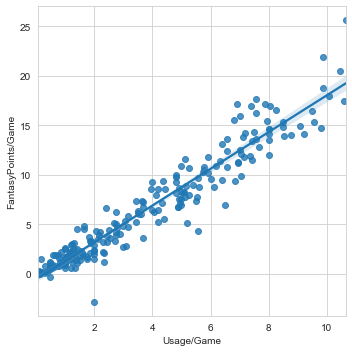

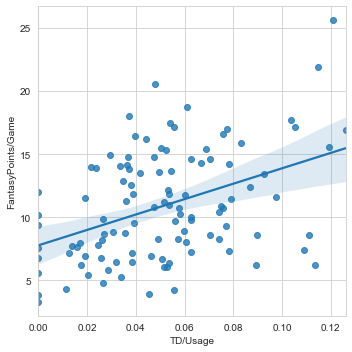

In [19]:
#just for styling. We imported seaborn earlier as sns.
sns.set_style('whitegrid')

#create a canvas with matplotlib
fig, ax = plt.subplots()
fig.set_size_inches(5,5)

#basic regression scatter plot with trendline
plot = sns.regplot(
x=wr_df['Usage/Game'],
y=wr_df['FantasyPoints/Game'],
scatter=True,)

plt.tight_layout();
plt.savefig('../static/images/WR_usage_per_game', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)



#How does efficiency correlate to fantasy football performance?
wr_df['TD/Usage'] = (wr_df['Rush TD']+ wr_df['Rec TD'])/(wr_df['Rush Att'] + wr_df['Rec Tgt'])
fig, ax = plt.subplots()
fig.set_size_inches(5,5)

#Make sure there is an adequete sample size
wr_df = wr_df[wr_df['Receptions'] > 20]
plot = sns.regplot(
x=wr_df['TD/Usage'],
y=wr_df['FantasyPoints/Game'],
scatter=True)

plt.tight_layout();
plt.savefig('../static/images/WR_TD_per_usage', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

In [20]:
from sklearn.model_selection import train_test_split
X = wr_df['Usage'].values.reshape(-1, 1)
Y = wr_df['FantasyPoints'].values.reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

regressor = LinearRegression()  
regressor.fit(x_train, y_train) #training the algorithm
y_pred = regressor.predict(x_test)

df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df.head()

,Actual,Predicted
0,97.1,98.962315
1,172.0,162.428161
2,181.1,202.815517
3,99.1,106.655145
4,262.9,281.667023


In [21]:
wr_df['FantasyPointPrediction'] = regressor.predict(X) # create a new column for usage

wr_df['FantasyPointPrediction'] = wr_df['FantasyPointPrediction'].apply(lambda x: round(x, 1))

In [22]:
wr_df_with_headshots = wr_df.merge(roster_df, left_on='Player', right_on='full_name', how='left')
wr_df_with_headshots = wr_df_with_headshots.sort_values(by='UsageRank')  

#reset the index to a range index 0 -> length
wr_df_with_headshots = wr_df_with_headshots.reset_index(drop=True)

wr_df_with_headshots.head(10)  

,Season,Player,Team,Pos,Age,Games Played,Pass Comp,Pass Att,Pass Yds,Pass TD,...,FantasyPoints,FantasyPoints/Game,Usage/Game,Usage,UsageRank,FantasyPointsRank,TD/Usage,FantasyPointPrediction,full_name,headshot_url
0,2020,Stefon Diggs,BUF,WR,27,16,0,0,0,0,...,328.6,20.54,10.44,167,1.0,3.0,0.047904,310.5,Stefon Diggs,https://a.espncdn.com/combiner/i?img=/i/headsh...
1,2020,DeAndre Hopkins,ARI,WR,28,16,0,0,0,0,...,287.8,17.99,10.06,161,2.0,4.0,0.037267,299.0,DeAndre Hopkins,https://a.espncdn.com/combiner/i?img=/i/headsh...
2,2020,Robert Woods,LAR,WR,28,16,0,0,0,0,...,245.1,15.32,9.56,153,3.0,13.5,0.052288,283.6,Robert Woods,https://a.espncdn.com/combiner/i?img=/i/headsh...
3,2020,Allen Robinson,CHI,WR,27,16,0,0,0,0,...,262.9,16.43,9.50,152,4.0,9.0,0.039474,281.7,Allen Robinson,https://a.espncdn.com/combiner/i?img=/i/headsh...
4,2020,Davante Adams,GNB,WR,28,14,0,0,0,0,...,358.4,25.60,10.64,149,5.0,1.0,0.120805,275.9,Davante Adams,https://a.espncdn.com/combiner/i?img=/i/headsh...
5,2020,Keenan Allen,LAC,WR,28,14,0,1,0,0,...,245.1,17.51,10.57,148,7.0,13.5,0.054054,274.0,Keenan Allen,https://a.espncdn.com/combiner/i?img=/i/headsh...
6,2020,Tyreek Hill,KAN,WR,26,15,0,0,0,0,...,328.9,21.93,9.87,148,7.0,2.0,0.114865,274.0,Tyreek Hill,https://a.espncdn.com/combiner/i?img=/i/headsh...
7,2020,Calvin Ridley,ATL,WR,26,15,0,0,0,0,...,281.5,18.77,9.87,148,7.0,5.0,0.060811,274.0,Calvin Ridley,https://a.espncdn.com/combiner/i?img=/i/headsh...
8,2020,Diontae Johnson,PIT,WR,24,15,0,0,0,0,...,221.8,14.79,9.80,147,9.0,21.0,0.047619,272.1,Diontae Johnson,https://a.espncdn.com/combiner/i?img=/i/headsh...
9,2020,Robby Anderson,CAR,WR,27,16,0,0,0,0,...,224.1,14.01,8.75,140,10.0,19.0,0.021429,258.6,Robby Anderson,https://a.espncdn.com/combiner/i?img=/i/headsh...


# TE: Compare usage vs efficiency


In [23]:
#Create new column for usage per game. Usage is defined as # of targets + carries
te_df['Usage/Game'] = (te_df['Rush Att'] + te_df['Rec Tgt'])/te_df['Games Played']

#round each row value to two decimal places
te_df['Usage/Game'] = te_df['Usage/Game'].apply(lambda x: round(x, 2))

te_df['Usage'] = te_df['Rec Tgt'] + te_df['Rush Att'] # create a new column for usage
te_df['UsageRank'] = te_df['Usage'].rank(ascending=False)
te_df['FantasyPointsRank'] = te_df['FantasyPoints'].rank(ascending=False)

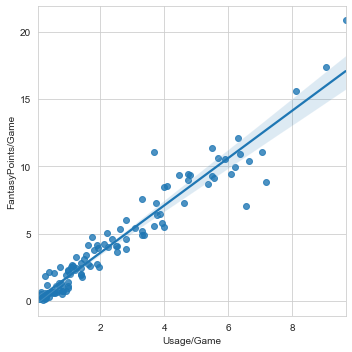

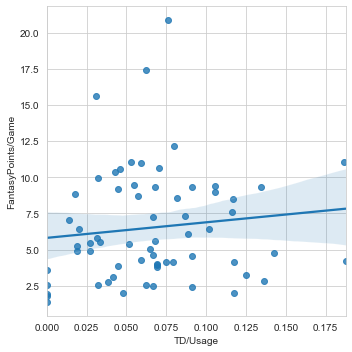

In [24]:
#just for styling. We imported seaborn earlier as sns.
sns.set_style('whitegrid')

#create a canvas with matplotlib
fig, ax = plt.subplots()
fig.set_size_inches(5,5)

#basic regression scatter plot with trendline
plot = sns.regplot(
x=te_df['Usage/Game'],
y=te_df['FantasyPoints/Game'],
scatter=True,)

plt.tight_layout();
plt.savefig('../static/images/TE_usage_per_game', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)



#How does efficiency correlate to fantasy football performance?
te_df['TD/Usage'] = (te_df['Rush TD']+ te_df['Rec TD'])/(te_df['Rush Att'] + te_df['Rec Tgt'])
fig, ax = plt.subplots()
fig.set_size_inches(5,5)

#Make sure there is an adequete sample size
te_df = te_df[te_df['Receptions'] > 10]
plot = sns.regplot(
x=te_df['TD/Usage'],
y=te_df['FantasyPoints/Game'],
scatter=True)

plt.tight_layout();
plt.savefig('../static/images/TE_TD_per_usage', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

In [25]:
from sklearn.model_selection import train_test_split
X = te_df['Usage'].values.reshape(-1, 1)
Y = te_df['FantasyPoints'].values.reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

regressor = LinearRegression()  
regressor.fit(x_train, y_train) #training the algorithm
y_pred = regressor.predict(x_test)

df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df.head()

,Actual,Predicted
0,116.4,114.881319
1,61.1,52.091402
2,54.2,67.788881
3,37.6,34.649759
4,149.3,135.811291


In [26]:
te_df['FantasyPointPrediction'] = regressor.predict(X) # create a new column for usage

te_df['FantasyPointPrediction'] = te_df['FantasyPointPrediction'].apply(lambda x: round(x, 1))

In [27]:
te_df_with_headshots = te_df.merge(roster_df, left_on='Player', right_on='full_name', how='left')
te_df_with_headshots = te_df_with_headshots.sort_values(by='UsageRank') 

#reset the index to a range index 0 -> length
te_df_with_headshots = te_df_with_headshots.reset_index(drop=True)

te_df_with_headshots.head(10) 

,Season,Player,Team,Pos,Age,Games Played,Pass Comp,Pass Att,Pass Yds,Pass TD,...,FantasyPoints,FantasyPoints/Game,Usage/Game,Usage,UsageRank,FantasyPointsRank,TD/Usage,FantasyPointPrediction,full_name,headshot_url
0,2020,Travis Kelce,KAN,TE,31,15,1,2,4,0,...,312.8,20.85,9.67,145,1.5,1.0,0.075862,254.4,Travis Kelce,https://a.espncdn.com/combiner/i?img=/i/headsh...
1,2020,Darren Waller,LVR,TE,28,16,0,0,0,0,...,278.6,17.41,9.06,145,1.5,2.0,0.062069,254.4,Darren Waller,https://a.espncdn.com/combiner/i?img=/i/headsh...
2,2020,Evan Engram,NYG,TE,26,16,0,0,0,0,...,141.0,8.81,7.19,115,3.0,15.0,0.017391,202.1,Evan Engram,https://a.espncdn.com/combiner/i?img=/i/headsh...
3,2020,Logan Thomas,WAS,TE,29,16,1,1,28,0,...,176.6,11.04,7.06,113,4.0,3.5,0.053097,198.6,Logan Thomas,https://a.espncdn.com/combiner/i?img=/i/headsh...
4,2020,T.J. Hockenson,DET,TE,23,16,0,0,0,0,...,175.3,10.96,6.38,102,5.0,5.0,0.058824,179.4,T.J. Hockenson,https://a.espncdn.com/combiner/i?img=/i/headsh...
5,2020,Noah Fant,DEN,TE,23,15,0,0,0,0,...,149.3,9.95,6.20,93,6.5,8.5,0.032258,163.7,Noah Fant,https://a.espncdn.com/combiner/i?img=/i/headsh...
6,2020,Hunter Henry,LAC,TE,26,14,0,0,0,0,...,145.3,10.38,6.64,93,6.5,12.0,0.043011,163.7,Hunter Henry,https://a.espncdn.com/combiner/i?img=/i/headsh...
7,2020,Eric Ebron,PIT,TE,27,15,0,0,0,0,...,141.8,9.45,6.07,91,8.0,14.0,0.054945,160.2,Eric Ebron,https://a.espncdn.com/combiner/i?img=/i/headsh...
8,2020,Dalton Schultz,DAL,TE,24,16,0,0,0,0,...,146.5,9.16,5.56,89,9.0,11.0,0.044944,156.7,Dalton Schultz,https://a.espncdn.com/combiner/i?img=/i/headsh...
9,2020,Hayden Hurst,ATL,TE,27,16,0,0,0,0,...,149.1,9.32,5.50,88,10.5,10.0,0.068182,155.0,Hayden Hurst,https://a.espncdn.com/combiner/i?img=/i/headsh...


# QB: Compare usage vs efficiency


In [28]:
yearly_stats_all_pos_df.columns

Index(['Season', 'Player', 'Team', 'Pos', 'Age', 'Games Played', 'Pass Comp',
       'Pass Att', 'Pass Yds', 'Pass TD', 'Pass Int', 'Rush Att', 'Rush Yds',
       'Rush Y/A', 'Rush TD', 'Rec Tgt', 'Receptions', 'Rec Yds', 'Rec Y/R',
       'Rec TD', 'Fumbles Lost', 'Total TD', 'PPR', 'FantasyPoints',
       'FantasyPoints/Game'],
      dtype='object')

In [29]:
#Create new column for usage per game. Usage is defined as # of targets + carries
qb_df['Usage/Game'] = (qb_df['Pass Att'] + qb_df['Rush Att'])/qb_df['Games Played']

#round each row value to two decimal places
qb_df['Usage/Game'] = qb_df['Usage/Game'].apply(lambda x: round(x, 2))

qb_df['Usage'] = qb_df['Pass Att'] + qb_df['Rush Att'] # create a new column for usage
qb_df['UsageRank'] = qb_df['Usage'].rank(ascending=False)
qb_df['FantasyPointsRank'] = qb_df['FantasyPoints'].rank(ascending=False)

In [30]:
qb_df

,Season,Player,Team,Pos,Age,Games Played,Pass Comp,Pass Att,Pass Yds,Pass TD,...,Rec TD,Fumbles Lost,Total TD,PPR,FantasyPoints,FantasyPoints/Game,Usage/Game,Usage,UsageRank,FantasyPointsRank
25,2020,A.J. McCarron,HOU,QB,30,2,1,1,20,0,...,0,0,0,0.8,0.8,0.40,0.50,1,83.0,77.0
69,2020,Aaron Rodgers,GNB,QB,37,16,372,526,4299,48,...,0,2,3,383.3,383.3,23.96,35.25,564,11.0,2.0
232,2020,Alex Smith,WAS,QB,36,8,168,252,1582,6,...,0,0,0,71.6,71.6,8.95,32.75,262,34.0,37.0
418,2020,Andy Dalton,DAL,QB,33,11,216,333,2170,14,...,0,1,0,136.9,136.9,12.45,32.82,361,27.0,30.0
685,2020,Baker Mayfield,CLE,QB,25,16,305,486,3563,26,...,0,4,1,248.6,248.6,15.54,33.75,540,17.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9256,2020,Trace McSorley,BAL,QB,25,2,3,10,90,1,...,0,0,0,9.3,9.3,4.65,7.50,15,68.5,60.5
9411,2020,Tua Tagovailoa,MIA,QB,22,10,186,290,1814,11,...,0,1,3,135.5,135.5,13.55,32.60,326,32.0,32.0
9426,2020,Tyler Bray,CHI,QB,29,1,1,5,18,0,...,0,0,0,0.7,0.7,0.70,5.00,5,78.0,78.0
9453,2020,Tyler Huntley,BAL,QB,22,2,3,5,15,0,...,0,0,0,2.9,2.9,1.45,7.50,15,68.5,66.0


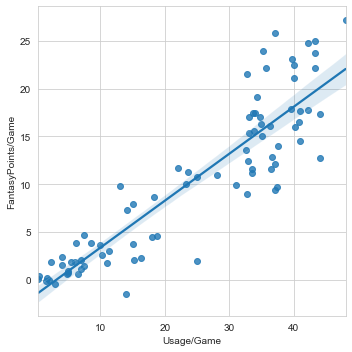

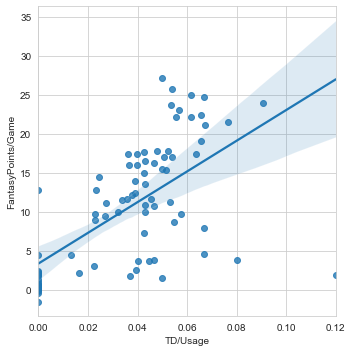

In [31]:
#just for styling. We imported seaborn earlier as sns.
sns.set_style('whitegrid')

#create a canvas with matplotlib
fig, ax = plt.subplots()
fig.set_size_inches(5,5)

#basic regression scatter plot with trendline
plot = sns.regplot(
x=qb_df['Usage/Game'],
y=qb_df['FantasyPoints/Game'],
scatter=True,)

plt.tight_layout();
plt.savefig('../static/images/QB_usage_per_game', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)



#How does efficiency correlate to fantasy football performance?
qb_df['TD/Usage'] = (qb_df['Pass TD']+ qb_df['Rush TD'])/(qb_df['Pass Att'] + qb_df['Rush Att'])
fig, ax = plt.subplots()
fig.set_size_inches(5,5)

#Make sure there is an adequete sample size
#qb_df = qb_df[qb_df['Receptions'] > 10]
plot = sns.regplot(
x=qb_df['TD/Usage'],
y=qb_df['FantasyPoints/Game'],
scatter=True)

plt.tight_layout();
plt.savefig('../static/images/QB_TD_per_usage', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

In [32]:
from sklearn.model_selection import train_test_split
X = qb_df['Usage'].values.reshape(-1, 1)
Y = qb_df['FantasyPoints'].values.reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

regressor = LinearRegression()  
regressor.fit(x_train, y_train) #training the algorithm
y_pred = regressor.predict(x_test)

df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df.head()

,Actual,Predicted
0,261.0,245.802622
1,9.3,-2.330190
2,14.5,10.836041
3,104.2,156.170973
4,374.4,319.229678


In [33]:
qb_df['FantasyPointPrediction'] = regressor.predict(X) # create a new column for usage

qb_df['FantasyPointPrediction'] = qb_df['FantasyPointPrediction'].apply(lambda x: round(x, 1))

In [34]:
qb_df_with_headshots = qb_df.merge(roster_df, left_on='Player', right_on='full_name', how='left')
qb_df_with_headshots = qb_df_with_headshots.sort_values(by='UsageRank')   

#reset the index to a range index 0 -> length
qb_df_with_headshots = qb_df_with_headshots.reset_index(drop=True)

qb_df_with_headshots.head(10) 

,Season,Player,Team,Pos,Age,Games Played,Pass Comp,Pass Att,Pass Yds,Pass TD,...,FantasyPoints,FantasyPoints/Game,Usage/Game,Usage,UsageRank,FantasyPointsRank,TD/Usage,FantasyPointPrediction,full_name,headshot_url
0,2020,Kyler Murray,ARI,QB,23,16,375,558,3971,26,...,378.7,23.67,43.19,691,1.0,3.0,0.053546,340.0,Kyler Murray,https://a.espncdn.com/combiner/i?img=/i/headsh...
1,2020,Josh Allen,BUF,QB,24,16,396,572,4544,37,...,396.1,24.76,42.12,674,2.0,1.0,0.066766,331.4,Josh Allen,https://a.espncdn.com/combiner/i?img=/i/headsh...
2,2020,Matt Ryan,ATL,QB,35,16,407,626,4581,26,...,282.4,17.65,40.94,655,3.0,12.0,0.042748,321.8,Matt Ryan,https://a.espncdn.com/combiner/i?img=/i/headsh...
3,2020,Justin Herbert,LAC,QB,22,15,396,595,4336,31,...,332.8,22.19,43.33,650,4.5,9.5,0.055385,319.2,Justin Herbert,https://a.espncdn.com/combiner/i?img=/i/headsh...
4,2020,Patrick Mahomes,KAN,QB,25,15,390,588,4740,38,...,374.4,24.96,43.33,650,4.5,4.0,0.061538,319.2,Patrick Mahomes,https://a.espncdn.com/combiner/i?img=/i/headsh...
5,2020,Russell Wilson,SEA,QB,32,16,384,558,4212,40,...,359.8,22.49,40.06,641,6.0,6.0,0.065523,314.7,Russell Wilson,https://a.espncdn.com/combiner/i?img=/i/headsh...
6,2020,Tom Brady,TAM,QB,43,16,401,610,4633,40,...,337.9,21.12,40.00,640,7.0,8.0,0.067187,314.2,Tom Brady,https://a.espncdn.com/combiner/i?img=/i/headsh...
7,2020,Deshaun Watson,HOU,QB,25,16,382,544,4823,33,...,369.3,23.08,39.62,634,8.0,5.0,0.056782,311.1,Deshaun Watson,https://a.espncdn.com/combiner/i?img=/i/headsh...
8,2020,Ben Roethlisberger,PIT,QB,38,15,399,608,3803,33,...,267.2,17.81,42.20,633,9.0,14.0,0.052133,310.6,Ben Roethlisberger,https://a.espncdn.com/combiner/i?img=/i/headsh...
9,2020,Jared Goff,LAR,QB,26,15,370,552,3952,20,...,240.0,16.00,40.20,603,10.0,19.5,0.039801,295.4,Jared Goff,https://a.espncdn.com/combiner/i?img=/i/headsh...


# Add to MySQL

In [6]:
# Create Engine and Pass in MySQL Connection

# Remote MySQL DB Connection  
remote_engine = create_engine(f"mysql://{remote_db_user}:{remote_db_pwd}@{remote_db_endpoint}:{remote_db_port}")
#print(f"postgresql://{local_db_user}:{local_db_pwd}@{local_db_endpoint}:{local_db_port}")

# Create a local database engine connection
remote_conn = remote_engine.connect()

# Create remote database
try:
    remote_conn.execution_options(isolation_level="AUTOCOMMIT").execute(f"CREATE DATABASE {remote_db_name}")
except Exception as e:
    print(e)

# Connect to remote database
try:
    remote_engine = create_engine(f"mysql://{remote_db_user}:{remote_db_pwd}@{remote_db_endpoint}:{remote_db_port}/{remote_db_name}")
    remote_conn = remote_engine.connect()
except Exception as e:
    print(e)  
    
#confirm tables
remote_engine.table_names()

(pymysql.err.ProgrammingError) (1007, "Can't create database 'fantasy_project'; database exists")
[SQL: CREATE DATABASE fantasy_project]
(Background on this error at: http://sqlalche.me/e/13/f405)


['fantasy_stats',
 'qb_df_with_headshots',
 'rb_df_with_headshots',
 'super_bowl_stats',
 'te_df_with_headshots',
 'wr_df_with_headshots']

In [ ]:
rb_df_with_headshots.to_sql(name='rb_df_with_headshots', if_exists='replace', con=remote_conn, index=False)
wr_df_with_headshots.to_sql(name='wr_df_with_headshots', if_exists='replace', con=remote_conn, index=False)
te_df_with_headshots.to_sql(name='te_df_with_headshots', if_exists='replace', con=remote_conn, index=False)
qb_df_with_headshots.to_sql(name='qb_df_with_headshots', if_exists='replace', con=remote_conn, index=False)

In [9]:
#confirm tables
remote_engine.table_names()

['2021_predictions',
 'fantasy_stats',
 'qb_df_with_headshots',
 'rb_df_with_headshots',
 'super_bowl_stats',
 'te_df_with_headshots',
 'wr_df_with_headshots']

# predictions df

In [5]:
#import our CSV file
predictions_df = pd.read_csv('table.csv')
predictions_df.head()


,SEASON,Player,Position,Predicted 2021 Fantasy Points,TDS,YDS,PASS YDS,PASS TD,PASS INT,RUSH YDS,RUSH TD,REC,REC YDS,REC TD
0,2021,Patrick Mahomes,QB,358.63868,40.000000,4888.666667,4622.666667,38.000000,7.666667,266.000000,2.000000,0.000000,0.000000,0.000000
1,2021,Deshaun Watson,QB,334.13868,33.666667,4751.333333,4280.000000,28.333333,9.333333,469.333333,5.000000,0.333333,2.000000,0.333333
2,2021,Justin Herbert,QB,333.13868,36.000000,4570.000000,4336.000000,31.000000,10.000000,234.000000,5.000000,0.000000,0.000000,0.000000
3,2021,Kyler Murray,QB,324.01368,30.500000,4528.000000,3846.500000,23.000000,12.000000,681.500000,7.500000,0.000000,0.000000,0.000000
4,2021,Russell Wilson,QB,321.63868,37.000000,4330.000000,3923.333333,35.333333,8.333333,410.333333,1.666667,0.333333,-3.666667,0.000000


In [8]:
predictions_df.to_sql(name='2021_predictions', if_exists='replace', con=remote_conn, index=False)

In [10]:
predictions_df.columns

Index(['SEASON', 'Player', 'Position', 'Predicted 2021 Fantasy Points', 'TDS',
       'YDS', 'PASS YDS', 'PASS TD', 'PASS INT', 'RUSH YDS', 'RUSH TD', 'REC',
       'REC YDS', 'REC TD'],
      dtype='object')